In [1]:
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

In [4]:
def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    psnr = -10 * torch.log10(mse)
    return psnr

class SRCNNLightningModule(pl.LightningModule):
    def __init__(self, lr=1e-4, scale=2, in_channels=3):
        super().__init__()
        self.model = SRCNN(in_channels=in_channels)
        self.loss_fn = torch.nn.L1Loss()
        self.lr = lr
        self.scale = scale

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale, mode='bicubic')
        return self.model(x)

    def training_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self.forward(lr)
        loss = self.loss_fn(sr, hr)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self.forward(lr)
        loss = self.loss_fn(sr, hr)
        psnr = calculate_psnr(sr, hr)
        self.log('val_loss', loss)
        self.log('val_psnr', psnr)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [5]:
checkpoint = torch.load('../logs/srcnn_lightning_Ychannel/version_1/checkpoints/epoch=49-step=2500.ckpt')
model = SRCNNLightningModule(lr=1e-4, scale=3, in_channels=1)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

SRCNNLightningModule(
  (model): SRCNN(
    (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (loss_fn): L1Loss()
)

In [37]:
img_LR = np.array(Image.open('/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_valid_LR_bicubic/X3/0801x3.png').convert('YCbCr'))
img_HR = np.array(Image.open('/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_valid_HR/0801.png').convert('RGB'))

img_LR_tensor = torch.tensor(img_LR).permute(2, 0, 1).unsqueeze(0).float() / 255.0
img_LR_tensor_Y = img_LR_tensor[:, 0:1, :, :]  # Y channel
img_LR_tensor_Cb = F.interpolate(img_LR_tensor[:, 1:2, :, :], scale_factor=3, mode='bicubic')
img_LR_tensor_Cr = F.interpolate(img_LR_tensor[:, 2:3, :, :], scale_factor=3, mode='bicubic')

img_HR_tensor = torch.tensor(img_HR).permute(2, 0, 1).unsqueeze(0).float() / 255.0

img_SR_tensor_Y = model(img_LR_tensor_Y)
img_SR_tensor = torch.cat((img_SR_tensor_Y, img_LR_tensor_Cb, img_LR_tensor_Cr), dim=1)

img_bicubic_tensor = F.interpolate(img_LR_tensor, scale_factor=3, mode='bicubic')

In [19]:
def show_images(lr, hr, sr):
    """Display LR and HR images side by side."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(lr.permute(1, 2, 0).numpy(), )
    axes[0].set_title('Low Resolution Image')
    axes[0].axis('off')

    axes[1].imshow(hr.permute(1, 2, 0).numpy())
    axes[1].set_title('High Resolution Image')
    axes[1].axis('off')
    
    axes[2].imshow(sr.permute(1, 2, 0).detach().numpy())
    axes[2].set_title('Super Resolution Image')
    axes[2].axis('off')

    plt.show()

def show_images_numpy(lr, hr, sr):
    """Display LR and HR images side by side using numpy arrays."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(lr)
    axes[0].set_title('Low Resolution Image')
    axes[0].axis('off')

    axes[1].imshow(hr)
    axes[1].set_title('High Resolution Image')
    axes[1].axis('off')
    
    axes[2].imshow(sr)
    axes[2].set_title('Super Resolution Image')
    axes[2].axis('off')

    plt.show()

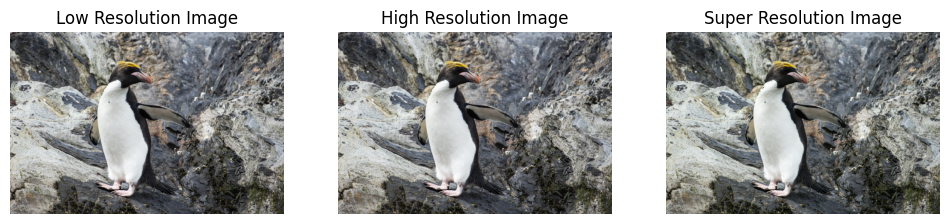

In [28]:
LR = np.array(Image.open('/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_valid_LR_bicubic/X3/0801x3.png').convert('RGB'))
SR = Image.fromarray((img_SR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8), mode='YCbCr')
SR = np.array(SR.convert('RGB'))
show_images_numpy(LR, np.array(img_HR), SR)

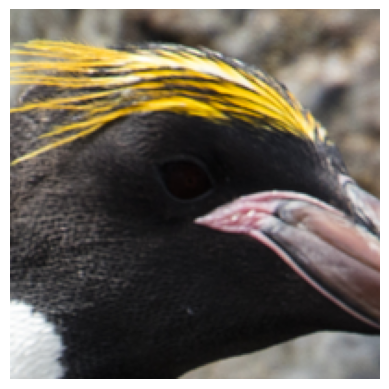

In [29]:
hr_ = img_HR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
patch = img_HR[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

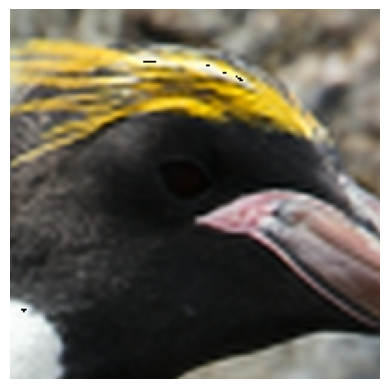

In [35]:
hr_ = img_HR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
patch = SR[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

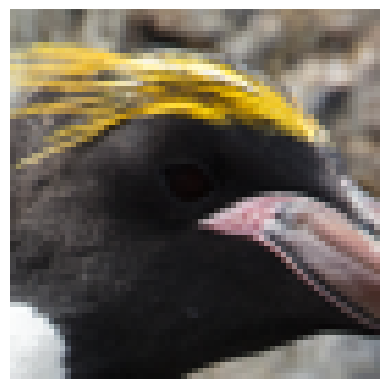

In [34]:
# lr_ = img_LR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
patch = LR[200//3:400//3, 800//3:1000//3, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

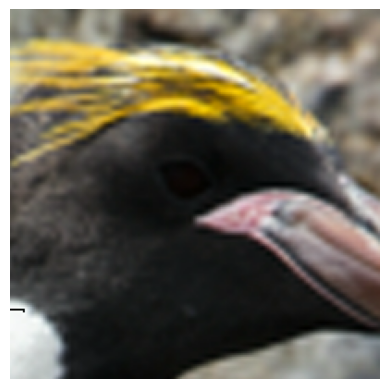

In [40]:
bicubic = img_bicubic_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
bicubic_rgb = Image.fromarray((bicubic * 255).astype(np.uint8), mode='YCbCr')
bicubic_rgb = np.array(bicubic_rgb.convert('RGB'))
patch = bicubic_rgb[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

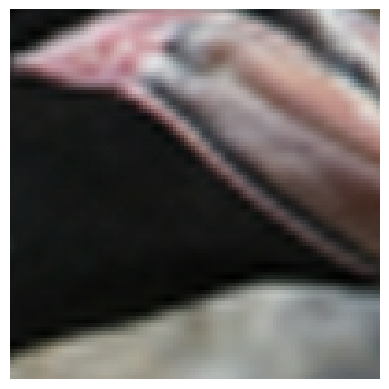

In [41]:
# lr_bicubic = F.interpolate(img_LR_tensor, scale_factor=3, mode='bicubic')
# lr_bicubic_ = lr_bicubic.squeeze(0).permute(1, 2, 0).detach().numpy()
patch = bicubic_rgb[300:400, 900:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

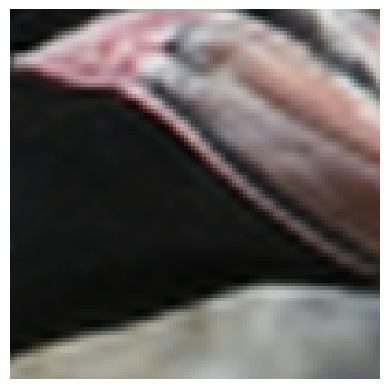

In [42]:
# sr_ = img_SR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
patch = SR[300:400, 900:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()